# Modeling

## Splitting

In [401]:
# Break or dataset to train and test based on "RENEWAL_DATE_C"
df_train=df1[(df1['RENEWAL_DATE_C'] < '2020-04-21')]
df_train.head()

,RENEWAL_DATE_C,IS_WON,Other_Plan,PlanGrid (Admin Console),PlanGrid (Advanced RFIs),PlanGrid (Crane - Infinite Sheets),PlanGrid (Dozer - 5000 Sheets),PlanGrid (Nailgun - 550 Sheets),PlanGrid (Submittals - Up to 50 Users),PlanGrid (Workspaces),...,field_report,home,issue,link,nav,photo,project,projecthub,sheet,team
OPPORTUNITY_ID,,,,,,,,,,,,,,,,,,,,,
opp101,2020-04-15 00:00:00,1.0,0,1,0,0,1,0,0,0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
opp103,2020-04-18 00:00:00,1.0,0,0,0,0,1,0,0,0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
opp104,2020-04-07 00:00:00,1.0,0,1,0,1,1,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
opp105,2020-04-02 00:00:00,1.0,0,0,0,0,1,0,0,0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
opp106,2020-04-14 00:00:00,1.0,0,0,0,1,1,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [402]:
df_test=df1[(df1['RENEWAL_DATE_C'] > '2020-04-21')]

Now we need split our traning set to traning and validation. 

In [403]:
Y = df_train['IS_WON']
X = df_train.drop(['RENEWAL_DATE_C','IS_WON'], axis=1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

## Sampling

Next we want to know if our target value for our traning set is balanced or not.

C:\Users\19498\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IS_WON', ylabel='count'>

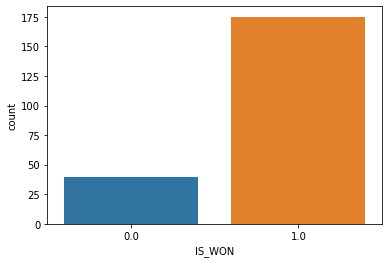

In [404]:
sns.countplot(Y_train)

It seems our dataset is unbalanced. We use SMOTE technique which means to create new synthetic False cases to balance our traning set. Figure below shows the effect of this technique. Note that we just do this for our traning not our validation, because we want them to represent the real test data.  

C:\Users\19498\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IS_WON', ylabel='count'>

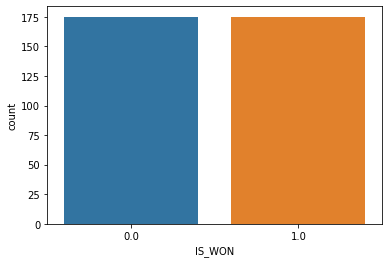

In [405]:
method = SMOTE()
X_train, Y_train=method.fit_sample(X_train, Y_train)
X_train=pd.DataFrame(X_train)
X_train.columns=X.columns
#X_train_s.head()
sns.countplot(Y_train)

## Model Selection

### Catboost

In [407]:
from catboost import CatBoostClassifier
cb=CatBoostClassifier()
cb.fit(X_train,Y_train)
cb_val = cb.predict(X_val)
cb_pred_train = cb.predict_proba(X_train)[:,1]
cb_pred_val = cb.predict_proba(X_val)[:,1]
cb_train_auc = roc_auc_score(Y_train, cb_pred_train)
cb_val_auc = roc_auc_score(Y_val, cb_pred_val)
print('AUC_Training:%.2f'%cb_train_auc)
print('AUC_Validation:%.2f'%cb_val_auc)

AUC_Training:0.97
AUC_Validation:0.78


### Logistic Regression

In [408]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr=LogisticRegression(random_state = 42)
lr.fit(X_train,Y_train)
lr_val = lr.predict(X_val)
lr_pred_train = lr.predict_proba(X_train)[:,1]
lr_pred_val = lr.predict_proba(X_val)[:,1]
lr_train_auc = roc_auc_score(Y_train, lr_pred_train)
lr_val_auc = roc_auc_score(Y_val, lr_pred_val)
print('AUC_Training:%.2f'%lr_train_auc)
print('AUC_Validation:%.2f'%lr_val_auc)


AUC_Training:0.91
AUC_Validation:0.82


### Random Forest Classifier

In [409]:
rf = RandomForestClassifier(max_depth = 6, random_state = 42) 
rf.fit(X_train,Y_train)
rf_pred_train = rf.predict_proba(X_train)[:,1]
rf_pred_val = rf.predict_proba(X_val)[:,1]
rf_train_auc = roc_auc_score(Y_train, rf_pred_train)
rf_val_auc = roc_auc_score(Y_val, rf_pred_val)
print('AUC_Training:%.2f'%rf_train_auc)
print('AUC_Validation:%.2f'%rf_val_auc)

AUC_Training:0.95
AUC_Validation:0.78


### Gradient Boosting

In [410]:
#Gradient Boosting
gb = GradientBoostingClassifier() 
gb.fit(X_train,Y_train)
gb_val = gb.predict(X_val)
gb_pred_train = gb.predict_proba(X_train)[:,1]
gb_pred_val = gb.predict_proba(X_val)[:,1]
gb_train_auc = roc_auc_score(Y_train, gb_pred_train)
gb_val_auc = roc_auc_score(Y_val, gb_pred_val)
print('AUC_Training:%.2f'%gb_train_auc)
print('AUC_Validation:%.2f'%gb_val_auc)

AUC_Training:0.97
AUC_Validation:0.76


### KNN

In [411]:
#KNN
knn = KNeighborsClassifier() 
knn.fit(X_train,Y_train)
knn_pred_train = knn.predict_proba(X_train)[:,1]
knn_pred_val = knn.predict_proba(X_val)[:,1]
knn_train_auc = roc_auc_score(Y_train, knn_pred_train)
knn_val_auc = roc_auc_score(Y_val, knn_pred_val)
print('AUC_Training:%.2f'%knn_train_auc)
print('AUC_Validation:%.2f'%knn_val_auc)

AUC_Training:0.93
AUC_Validation:0.72


### Stochastic Gradient Descent

In [412]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgd.fit(X_train,Y_train)
sgd_val = sgd.predict(X_val)
sgd_pred_train = sgd.predict_proba(X_train)[:,1]
sgd_pred_val = sgd.predict_proba(X_val)[:,1]
sgd_train_auc = roc_auc_score(Y_train, sgd_pred_train)
sgd_val_auc = roc_auc_score(Y_val, sgd_pred_val)
print('AUC_Training:%.2f'%sgd_train_auc)
print('AUC_Validation:%.2f'%sgd_val_auc)

AUC_Training:0.84
AUC_Validation:0.76


### Ada Boost Classifier

In [413]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(random_state = 42)
adb.fit(X_train,Y_train)
adb_val = adb.predict(X_val)
adb_pred_train = adb.predict_proba(X_train)[:,1]
adb_pred_val = adb.predict_proba(X_val)[:,1]
adb_train_auc = roc_auc_score(Y_train, adb_pred_train)
adb_val_auc = roc_auc_score(Y_val, adb_pred_val)
print('AUC_Training:%.2f'%adb_train_auc)
print('AUC_Validation:%.2f'%adb_val_auc)

AUC_Training:0.93
AUC_Validation:0.79


## Comparison

We use AUC metric to compare different models. AUC is area under the ROC curve. Precision and recall are calculated using single threshold but AUC takes all possible thresholds for calculating FPR and TPR. So it is more powerfull.

Logistic Regression works better on our validation set, so we choose Logistic Regression as the best model that predict renewal.

In [414]:
print('AUC_Training_Logistic_Regression:%.2f'%lr_train_auc)
print('AUC_Validation_Logistic_Regression:%.2f'%lr_val_auc)


AUC_Training_Logistic_Regression:0.91
AUC_Validation_Logistic_Regression:0.82


In [415]:
#Logistic Regression for traning set
print(classification_report(Y_train, np.argmax(lr.predict_proba(X_train), axis=1)))


              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       175
         1.0       0.88      0.81      0.84       175

    accuracy                           0.85       350
   macro avg       0.85      0.85      0.85       350
weighted avg       0.85      0.85      0.85       350



In [416]:
#Logistic Regression for Validation set
print(classification_report(Y_val, np.argmax(lr.predict_proba(X_val), axis=1)))

              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60        28
         1.0       0.83      0.82      0.82        65

    accuracy                           0.75        93
   macro avg       0.71      0.71      0.71        93
weighted avg       0.76      0.75      0.75        93



## Most Important Feature Based on Random Forest

Top 10 features are: 
PlanGrid (Nailgun - 550 Sheets)
link
projecthub
PlanGrid (Admin Console)
PlanGrid (Crane - Infinite Sheets)
PlanGrid (Dozer - 5000 Sheets)
PlanGrid (Workspaces)
team
photo
field_report


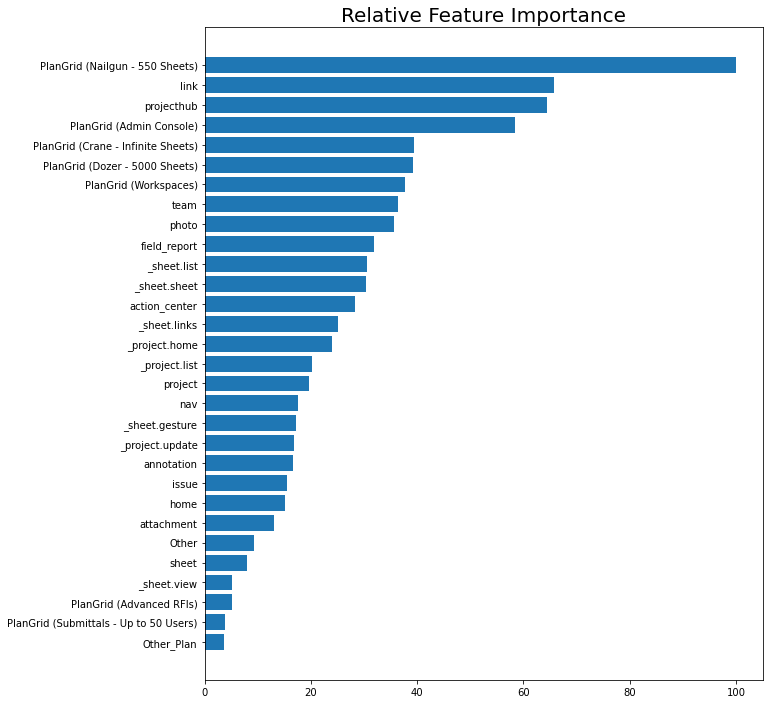

In [417]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, Y_train)
importances = random_forest.feature_importances_

feature_importance = 100.0 * (importances / importances.max()) # relative importance
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_train.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print ('Top 10 features are: ')
for feature in feature_names_sort[::-1][:10]:
    print (feature)

# plot top features
plt.figure(figsize=(10, 12))
plt.barh(pos[:], feature_importance[sorted_idx[:]], align='center')
plt.yticks(pos[:], feature_names_sort[:])
plt.title('Relative Feature Importance', fontsize=20)
plt.show()